## **Employment Prediction with XGBoost**

The goal of this project was to explore applying XGBoost on panel economic data to forecast next year's employment growth by industry using publicly available business dynamics data. Rather than focusing on model complexity upfront, we have emphasized building a forecasting framework that is temporally sound and robust given a relatively small sample size.

In [1]:
import requests
from time import sleep
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


### **Data**

The data used in this notebook comes from The Business Dynamics Statistics (BDS) time series dataset from the US Census Bureau. The Business Dynamics Statistics dataset provides a rich longitudinal view of employment dynamics across industries. Its structure imposes important constraints that influence the modeling approach used in this notebook. In particular, the annual frequency of the observations limits our ability to study short-term dynamics. Moreover, the time span covered by the data includes periods of structural disruption, such as major recessions and pandemic era shocks, that are not explicitly modeled. The data is retrieved using the API query defined below.



In [2]:
# example api calls
#r = requests.get("https://api.census.gov/data/timeseries/bds?get=NAME,NAICS_LABEL,YEAR,DENOM,FIRM,ESTAB,EMP&for=county:*&time=2022&NAICS=00")
#r = requests.get("https://api.census.gov/data/timeseries/bds?get=NAME,NAICS_LABEL,YEAR,DENOM,FIRM,ESTAB,EMP&for=county:*&time=2022")

BASE_URL = "https://api.census.gov/data/timeseries/bds"

AGG_NAICS_CODES = [
    #"00",      # All industries
    "31-33",   # Manufacturing
    "44-45",   # Retail trade
    "48-49",   # Transportation & Warehousing
    "51",      # Information
    "52",      # Finance & Insurance
    "54",      # Professional, Scientific, Technical
    "62",      # Health Care & Social Assistance
]

YEARS_PULLED = list(range(1978, 2024))#[2019,2020,2021,2022, 2023] # Available years are 1978-2023

def fetch_bds_county_by_naics(
    naics_code: str,
    year: int = 2023,
    sleep_sec: float = 0.3,
) -> pd.DataFrame:
    """
    Pull BDS time series data at county level for a single NAICS aggregate code.
    """

    params = {
        "get": "NAME,NAICS_LABEL,YEAR,DENOM,FIRM,ESTAB,EMP,JOB_CREATION,JOB_DESTRUCTION,JOB_CREATION_BIRTHS,JOB_CREATION_CONTINUERS,JOB_DESTRUCTION_DEATHS,JOB_DESTRUCTION_CONTINUERS",
        "for": "county:*",
        "in": "state:*",
        "time": str(year),
        "NAICS": naics_code,
    }

    r = requests.get(BASE_URL, params=params, timeout=60)
    r.raise_for_status()

    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # Keep track of which NAICS code produced these rows
    df["NAICS"] = naics_code

    # Gentle rate limiting
    sleep(sleep_sec)

    return df

def fetch_bds_by_naics(
    naics_code: str,
    year: int = 2023,
    sleep_sec: float = 0.3,
) -> pd.DataFrame:
    """
    Pull BDS time series data at national level for a single NAICS aggregate code.
    """

    params = {
        "get": "NAME,NAICS_LABEL,YEAR,DENOM,FIRM,ESTAB,EMP,JOB_CREATION,JOB_DESTRUCTION,JOB_CREATION_BIRTHS,JOB_CREATION_CONTINUERS,JOB_DESTRUCTION_DEATHS,JOB_DESTRUCTION_CONTINUERS",
        "for": "us:1",
        #"in": "state:*",
        "time": str(year),
        "NAICS": naics_code,
    }

    r = requests.get(BASE_URL, params=params, timeout=60)
    r.raise_for_status()

    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # Keep track of which NAICS code produced these rows
    df["NAICS"] = naics_code

    # Gentle rate limiting
    sleep(sleep_sec)

    return df


In [3]:
pull_level = "national" # "national" or "county"

BASE_URL = "https://api.census.gov/data/timeseries/bds"

AGG_NAICS_CODES = [
    # "00",      # All industries
    "31-33",   # Manufacturing
    "44-45",   # Retail trade
    "48-49",   # Transportation & Warehousing
    "51",      # Information
    "52",      # Finance & Insurance
    "54",      # Professional, Scientific, Technical
    "62",      # Health Care & Social Assistance
]

YEARS_PULLED = list(range(1978, 2024)) # Available years are 1978-2023
YEARS_PULLED.reverse()

if pull_level == "county":
  # Pull each NAICS code and year and combine
  dfs = []
  for year_pull in YEARS_PULLED:
    print(f"Pulling Year={year_pull} ...")
    for code in AGG_NAICS_CODES:
      try:
          df_code = fetch_bds_county_by_naics(code, year=year_pull)
          dfs.append(df_code)
      except requests.HTTPError as e:
          print(f" Failed NAICS={code}: {e}")
      except Exception as e:
          print(f" Unexpected error NAICS={code}: {e}")

  df = pd.concat(dfs, ignore_index=True)

  # basic cleaning and type conversion
  for c in ["YEAR", "DENOM", "FIRM", "ESTAB", "EMP",'JOB_CREATION','JOB_DESTRUCTION','JOB_CREATION_BIRTHS','JOB_CREATION_CONTINUERS','JOB_DESTRUCTION_DEATHS','JOB_DESTRUCTION_CONTINUER']:
      if c in df.columns:
          df[c] = pd.to_numeric(df[c], errors="coerce")

  # create unique id for each county
  if "state" in df.columns:
      df["state"] = df["state"].astype(str).str.zfill(2)
  if "county" in df.columns:
      df["county"] = df["county"].astype(str).str.zfill(3)
  if set(["state", "county"]).issubset(df.columns):
      df["county_fips"] = df["state"] + df["county"]

  # Convert all column names to lowercase
  df = df.rename(columns=str.lower)
  print(df.columns)
  df = df.rename(columns={
      'name':'county_name',
      'naics_label':'industry_name',
      'denom':'dhs_denominator',
      'firm':'firm_count',
      'estab':'establishment_count',
      'emp':'employment_count',
      'job_creation':'jobs_created',
      'job_destruction':'jobs_destroyed',
      'job_creation_births':'jobs_created_births',
      'job_creation_continuers':'jobs_created_continuers',
      'job_destruction_deaths':'jobs_destroyed_deaths',
      'job_destruction_continuers':'jobs_destroyed_continuers',
      'naics':'industry_code',
      'county_fips':'county_id'
  })

  #df.to_csv("bds_data_2019_2023.csv", index=False)
  print(df.shape)
  df.columns

elif pull_level == "national":
  # Pull each NAICS code and year and combine
  dfs = []
  for year_pull in YEARS_PULLED:
    for code in AGG_NAICS_CODES:
    #for year_pull in YEARS_PULLED:
      try:
          df_code = fetch_bds_by_naics(code, year=year_pull)
          dfs.append(df_code)
      except requests.HTTPError as e:
          print(f" Failed NAICS={code}: {e}")
      except Exception as e:
          print(f" Unexpected error NAICS={code}: {e}")

  df = pd.concat(dfs, ignore_index=True)

  # basic cleaning and type conversion
  for c in ["YEAR", "DENOM", "FIRM", "ESTAB", "EMP",'JOB_CREATION','JOB_DESTRUCTION','JOB_CREATION_BIRTHS','JOB_CREATION_CONTINUERS','JOB_DESTRUCTION_DEATHS','JOB_DESTRUCTION_CONTINUER']:
      if c in df.columns:
          df[c] = pd.to_numeric(df[c], errors="coerce")

  # Convert all column names to lowercase
  df = df.rename(columns=str.lower)
  print(df.columns)
  df = df.rename(columns={
      'naics_label':'industry_name',
      'denom':'dhs_denominator',
      'firm':'firm_count',
      'estab':'establishment_count',
      'emp':'employment_count',
      'job_creation':'jobs_created',
      'job_destruction':'jobs_destroyed',
      'job_creation_births':'jobs_created_births',
      'job_creation_continuers':'jobs_created_continuers',
      'job_destruction_deaths':'jobs_destroyed_deaths',
      'job_destruction_continuers':'jobs_destroyed_continuers',
      'naics':'industry_code'
  })

  df_raw = df.copy()
  print(df.shape)
  list(df.columns)


Index(['name', 'naics_label', 'year', 'denom', 'firm', 'estab', 'emp',
       'job_creation', 'job_destruction', 'job_creation_births',
       'job_creation_continuers', 'job_destruction_deaths',
       'job_destruction_continuers', 'time', 'naics', 'us'],
      dtype='object')
(322, 16)


# **National Breakdown by Industry**


In [4]:
df_raw.head()

,name,industry_name,year,dhs_denominator,firm_count,establishment_count,employment_count,jobs_created,jobs_destroyed,jobs_created_births,jobs_created_continuers,jobs_destroyed_deaths,jobs_destroyed_continuers,time,industry_code,us
0,United States,Manufacturing,2023,12216051,220696,268269,12293106,1166340,1011814,262904,903436,235498,776316,2023,31-33,1
1,United States,Retail trade,2023,16041670,579638,980272,16068436,1485006,1432774,479805,1005201,377117,1055657,2023,44-45,1
2,United States,Transportation and warehousing,2023,6384197,198284,254427,6450641,869317,740339,289723,579594,227346,512993,2023,48-49,1
3,United States,Information,2023,3543357,73823,141691,3539955,440419,449216,123195,317224,153546,295670,2023,51,1
4,United States,Finance and insurance,2023,6846328,214433,438240,6912028,1108533,982064,307479,801054,301423,680641,2023,52,1


### **Initial Feature Engineering**

When we pull the data by industry at the national level for every year available (1978-2023) our dataset contains 322 observations spread evenly across 7 industry groups. These observations form a panel time series with base features that are economically meaningfull. Given the size of the available dataset we believe it is appropriate and prudent to constrain the complexity of our XGBoost model and benchmark against a pooled linear regression model to ensure that any potential nonlinear gains are robust rather than artifacts of overfitting.

To constrain complexity we will not over engineer our feature set but rather utilize a relatively small set of lagged level, momentum, and intensity features that are likely to have a high signal to noise ratio.


In [5]:
def build_emp_growth_dataset(
    df: pd.DataFrame,
    *,
    group_key: str = "industry_code",
    time_col: str = "year",
) -> pd.DataFrame:
    """
    Builds a leakage-safe dataset to predict next-year employment growth by industry.

    """
    df = df.copy()

    required = [
        group_key, time_col,
        "firm_count",
        "establishment_count",
        "employment_count",
        "jobs_created",
        "jobs_destroyed",
        "jobs_created_births",
        "jobs_created_continuers",
        "jobs_destroyed_deaths",
        "jobs_destroyed_continuers",
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Ensure numeric types for modeling fields
    num_cols = [
        "firm_count",
        "establishment_count",
        "employment_count",
        "jobs_created",
        "jobs_destroyed",
        "jobs_created_births",
        "jobs_created_continuers",
        "jobs_destroyed_deaths",
        "jobs_destroyed_continuers",
    ]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Sort to ensure shifts are previous year within each industry
    df = df.sort_values([group_key, time_col]).reset_index(drop=True)

    g = df.groupby(group_key, sort=False)

    # Target: next-year employment growth
    df["employment_next"] = g["employment_count"].shift(-1)
    df["emp_growth_next"] = (df["employment_next"] - df["employment_count"]) / df["employment_count"].replace(0, np.nan)

    # Lagged stock levels (scale / structure)
    df["employment_count_lag1"] = g["employment_count"].shift(1)
    df["firm_count_lag1"] = g["firm_count"].shift(1)
    df["establishment_count_lag1"] = g["establishment_count"].shift(1)

    # Momentum: employment growth at time t, lagged to predict t+1
    df["employment_growth"] = (
        (df["employment_count"] - df["employment_count_lag1"])
        / df["employment_count_lag1"].replace(0, np.nan)
    )
    df["employment_growth_lag1"] = g["employment_growth"].shift(1)

    # Lagged flows
    flow_cols = [
        "jobs_created",
        "jobs_destroyed",
        "jobs_created_births",
        "jobs_created_continuers",
        "jobs_destroyed_deaths",
        "jobs_destroyed_continuers",
    ]
    for c in flow_cols:
        df[f"{c}_lag1"] = g[c].shift(1)

    # Net jobs (lagged)
    df["net_jobs_lag1"] = df["jobs_created_lag1"] - df["jobs_destroyed_lag1"]

    # Flow intensity rates (from lagged values only)
    emp_lag1_safe = df["employment_count_lag1"].replace(0, np.nan)

    df["jobs_created_rate_lag1"] = df["jobs_created_lag1"] / emp_lag1_safe
    df["jobs_destroyed_rate_lag1"] = df["jobs_destroyed_lag1"] / emp_lag1_safe
    df["net_job_creation_rate_lag1"] = df["net_jobs_lag1"] / emp_lag1_safe

    # decomposition rates
    df["birth_job_creation_rate_lag1"] = df["jobs_created_births_lag1"] / emp_lag1_safe
    df["death_job_destruction_rate_lag1"] = df["jobs_destroyed_deaths_lag1"] / emp_lag1_safe


    # Final modeling frame
    feature_cols = [
        "employment_count_lag1",
        "firm_count_lag1",
        "establishment_count_lag1",
        "employment_growth_lag1",
        "jobs_created_rate_lag1",
        "jobs_destroyed_rate_lag1",
        "net_job_creation_rate_lag1",
        "birth_job_creation_rate_lag1",
        "death_job_destruction_rate_lag1",
    ]

    out_cols = ["industry_name",group_key, time_col, "emp_growth_next"] + feature_cols

    df_model = df[out_cols].dropna(subset=["emp_growth_next"] + feature_cols).copy()

    return df_model


In [6]:
# engineneer features
df = df_raw.copy()
df_model = build_emp_growth_dataset(df, group_key="industry_code", time_col="year")
df_model['industry_name'] = df_model['industry_name'].astype('category')
list(df_model.columns)


['industry_name',
 'industry_code',
 'year',
 'emp_growth_next',
 'employment_count_lag1',
 'firm_count_lag1',
 'establishment_count_lag1',
 'employment_growth_lag1',
 'jobs_created_rate_lag1',
 'jobs_destroyed_rate_lag1',
 'net_job_creation_rate_lag1',
 'birth_job_creation_rate_lag1',
 'death_job_destruction_rate_lag1']

### **Lagged Feature Design**

All features in this notebook are constructed using lagged information to avoid look-ahead bias. The feature set focuses on employment levels, growth rates, and job creation and destruction measures observed in the prior year.

Given the relatively small sample size, this design favors theoretically motivated signals over an expansive set of engineered features. Introducing additional lags or transformations without strong justification would increase model variance and reduce interpretability, particularly in a forecasting context.


### **Target Variable**

The prediction target in this analysis is next year's employment growth at the industry level. Specifically, the model predicts the proportional change in employment from year $t$ to year $t+1$.

Defining the target in this way enforces a strictly forward looking setup and ensures that all predictors are constructed using information available at the time of prediction. This formulation aligns with standard practices in economic growth modeling and supports meaningful interpretation of forecast errors.

Plot of next year's employment growth per industry from 1978 to 2023 is shown below.

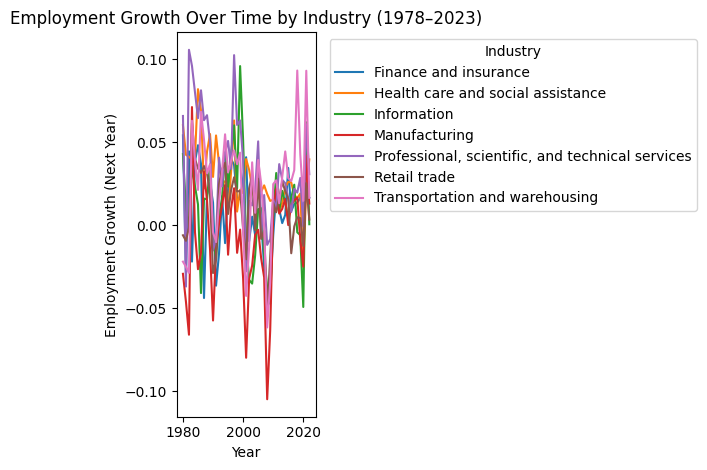

In [9]:
# Group by industry and plot each one
for industry, g in df_model.groupby("industry_name",observed=True):
    plt.plot(g["year"], g["emp_growth_next"], label=industry)

plt.xlabel("Year")
plt.ylabel("Employment Growth (Next Year)")
plt.title("Employment Growth Over Time by Industry (1978–2023)")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### **Feature Selection**

To select our features, we first organize the features by the type of information they convey and then select the strongest feature from each class in an effort to reduce the amount of redundent information accessible to the model. First, we consider the set of potential level features. These features tell us the size and capacity of an industry and serve to anchor growth predictions. To begin we will use only employment as it provides the most direct measure of scale. To capture momentum information we will use empployment growth lagged by 1 year. Using this feature will allow the model to access information about the persistence of economic activity. To capture intensity information we will use the net job creation rate lagged by 1 year. This feature will allow the model to access information about the strength of observed changes. After a base-line is established using these 3 features we will explore the inclusion of additional features.

**Initial feature Set**
*   employment lagged 1 year
*   empployment growth lagged 1 year
*   net job creation rate lagged by 1 year



### **Model Selection**

Model selection is guided by the goal of producing accurate and stable out-of-sample forecasts of next-period employment growth. Rather than optimizing a single model for maximum in-sample fit, the emphasis is on comparing models of increasing complexity within a consistent evaluation framework to understand the trade-offs between simplicity, flexibility, and robustness over time.

Three models are considered. A naïve baseline serves as a lower bound on performance and provides a reference point for forecast difficulty across years. A linear regression model is included as a transparent and widely used benchmark that captures additive relationships among lagged employment and firm-level features. Finally, an XGBoost model is used to represent a more flexible, nonlinear approach capable of learning interactions and threshold effects commonly present in economic and labor market data.

The models are trained using the same feature set and evaluated using a rolling-origin framework to avoid look-ahead bias. Hyperparameters for XGBoost are chosen conservatively to balance predictive performance and generalization rather than aggressively optimized for any single test year. This setup ensures that differences in performance primarily reflect model capability rather than differences in data access or evaluation procedure.


In [16]:
features_base = [
    "industry_name",
    "employment_count_lag1",
    "employment_growth_lag1",
    "net_job_creation_rate_lag1",
]

features_full = [
    "industry_name",
    "employment_count_lag1",
    "firm_count_lag1",
    "establishment_count_lag1",
    "employment_growth_lag1",
    "jobs_created_rate_lag1",
    "jobs_destroyed_rate_lag1",
    "net_job_creation_rate_lag1",
    "birth_job_creation_rate_lag1",
    "death_job_destruction_rate_lag1",
]

features = features_base # select feature set

target = "emp_growth_next"


def rolling_origin_eval(
    df_model: pd.DataFrame,
    *,
    group_col: str = "industry_name",
    time_col: str = "year",
    features: list[str] = features_base,
    target: str = target,
    min_train_years: int = 3,
    xgb_params: dict | None = None,
) -> pd.DataFrame:
    """
    Walk-forward evaluation:
      For each test year Y, train on years < Y and test on year == Y.

    Returns ONE row per test_year with:
      - shared fold info (n_train, n_test)
      - Linear metrics (rmse_lr, mae_lr)
      - XGBoost metrics (rmse_xgb, mae_xgb)
      - pct_diff_rmse_xgb_vs_lr: percent RMSE change relative to Linear
        (negative => XGBoost is better; positive => XGBoost is worse)
    """
    df = df_model.copy().sort_values([time_col, group_col])

    years = sorted(df[time_col].unique())
    if len(years) < (min_train_years + 1):
        raise ValueError(
            f"Not enough years for rolling-origin: have {len(years)} years, "
            f"need at least {min_train_years + 1}."
        )

    # Conservative XGBoost defaults for small data
    if xgb_params is None:
        xgb_params = dict(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=10,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0,
            early_stopping_rounds=20,
            enable_categorical=True,
            objective="reg:squarederror",
            random_state=42,
        )

    rows = []
    rmse_rows = []
    mae_rows = []

    for i in range(min_train_years, len(years)):
        test_year = years[i]
        train_years = years[:i]

        train_df = df[df[time_col].isin(train_years)].dropna(subset=features + [target])
        test_df = df[df[time_col] == test_year].dropna(subset=features + [target])

        if len(train_df) < 20 or len(test_df) < 5:
            continue

        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]

        X_train['industry_name'] = X_train['industry_name'].astype('category')
        X_test['industry_name'] = X_test['industry_name'].astype('category')

        X_train_lr = X_train.drop(columns=["industry_name"])
        X_test_lr = X_test.drop(columns=["industry_name"])

        # naive baseline
        rmse_naive = np.sqrt(((y_train - y_train.mean())**2).mean())

        # Linear regression
        lr = LinearRegression()
        lr.fit(X_train_lr, y_train)
        pred_lr = lr.predict(X_test_lr)

        rmse_lr = root_mean_squared_error(y_test, pred_lr)
        mae_lr = mean_absolute_error(y_test, pred_lr)

        # XGBoost
        xgb = XGBRegressor(**xgb_params)
        xgb.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        pred_xgb = xgb.predict(X_test)

        rmse_xgb = root_mean_squared_error(y_test, pred_xgb)
        mae_xgb = mean_absolute_error(y_test, pred_xgb)

        # Percent difference: (XGB - LR) / LR * 100
        pct_diff_rmse = np.nan
        if rmse_lr != 0 and not np.isnan(rmse_lr):
            pct_diff_rmse = 100.0 * (rmse_xgb - rmse_lr) / rmse_lr

        # Percent difference: (XGB - LR) / LR * 100
        pct_diff_mae = np.nan
        if mae_lr != 0 and not np.isnan(mae_lr):
            pct_diff_mae = 100.0 * (mae_xgb - mae_lr) / mae_lr

        rows.append(
            {
                "test_year": test_year,
                "n_train": len(train_df),
                #"n_test": len(test_df),
                "rmse_naive": rmse_naive,
                "rmse_lr": rmse_lr,
                "mae_lr": mae_lr,
                "rmse_xgb": rmse_xgb,
                "mae_xgb": mae_xgb,
                "pct_diff": pct_diff_rmse,
            }
        )

        rmse_rows.append(
            {
                "test_year": test_year,
                "n_train": len(train_df),
                "n_test": len(test_df),
                "rmse_naive": rmse_naive,
                "rmse_lr": rmse_lr,
                "rmse_xgb": rmse_xgb,
                "pct_diff": pct_diff_rmse,
            }
        )

        mae_rows.append(
            {
                "test_year": test_year,
                "n_train": len(train_df),
                "n_test": len(test_df),
                "mae_lr": mae_lr,
                "mae_xgb": mae_xgb,
                "pct_diff": pct_diff_mae,
            }
        )


    rmse_results = pd.DataFrame(rmse_rows).sort_values("test_year").reset_index(drop=True)
    mae_results = pd.DataFrame(mae_rows).sort_values("test_year").reset_index(drop=True)
    return rmse_results, mae_results

rmse_results, mae_results = rolling_origin_eval(df_model, min_train_years=30)

print(rmse_results)

# Summary across folds
rmse_summary = rmse_results[["rmse_naive","rmse_lr", "rmse_xgb", "pct_diff"]].agg(["mean", "std", "count"])
print(rmse_summary)

print(mae_results)

# Summary across folds
mae_summary = mae_results[["mae_lr", "mae_xgb", "pct_diff"]].agg(["mean", "std", "count"])
print(mae_summary)


    test_year  n_train  n_test  rmse_naive   rmse_lr  rmse_xgb   pct_diff
0        2010      210       7    0.035273  0.026502  0.008755 -66.965256
1        2011      217       7    0.034744  0.021268  0.009389 -55.851835
2        2012      224       7    0.034236  0.010932  0.009510 -13.009950
3        2013      231       7    0.033756  0.011872  0.009650 -18.712294
4        2014      238       7    0.033303  0.014731  0.013145 -10.763971
5        2015      245       7    0.032897  0.014835  0.012225 -17.593024
6        2016      252       7    0.032500  0.013826  0.013787  -0.282274
7        2017      259       7    0.032139  0.008667  0.008085  -6.713632
8        2018      266       7    0.031758  0.027522  0.026905  -2.242945
9        2019      273       7    0.031733  0.016446  0.012445 -24.328521
10       2020      280       7    0.031453  0.032714  0.029711  -9.180938
11       2021      287       7    0.031523  0.039662  0.038887  -1.954231
12       2022      294       7    0.03

### **Model Comparison**

The naive baseline, the pooled linear regression model, and the XGBoost model were evaluated using a rolling-origin framework, where each test year is predicted using all available historical data up to that point. Forecast accuracy for each model was measured using both root mean squared error (RMSE) and mean absolute error (MAE).

The naive baseline provides a useful point of reference. It exhibits stable error across all test years. Its consistency suggests that the overall difficulty of forecasting remains relatively constant over time and that improvements from the more sophisticated models reflect genuine signal capture rather than changing data conditions.

Both learned models improve substantially over the naive baseline. This confirms that lagged employment and firm level dynamics captured by our features contain meaningful predictive information. Linear regression performs well in many years, improving as the training sample grows. However its performance is uneven. During periods associated with broader economic disruption (ie Covid in 2020 and 2021), For example in 2020 and 2021 linear regression errors exceed those of the naive model. This demonstrates the limitations of a strictly linear specification in the presence of structural change (ie Covid in 2020 and 2012).

XGBoost consistently outperforms linear regression across nearly all test years and for both RMSE and MAE. The performance gains are especially pronounced in earlier years with smaller training samples, where XGBoost reduces forecast error by more than 50 percent in some cases. This suggests that nonlinear effects and feature interactions play an important role in employment growth dynamics and that tree based methods are better suited to capture these patterns when data is limited.

As the training dataset expands over time, the performance gap between the two learned models narrows, but XGBoost maintains a consistent edge. Notably, during periods of heightened volatility (ie Covid), XGBoost demonstrates greater robustness, producing lower errors than linear regression even when both models experience performance degradation.

Overall, this comparison highlights a clear tradeoff between simplicity and flexibility. Linear regression captures a substantial portion of the signal and offers interpretability and stability. XGBoost provides superior predictive accuracy and resilience to nonlinearities and regime shifts. These results motivate the use of tree based ensemble models for employment forecasting tasks where relationships evolve over time and structural change is likely.


### **Limitations**

Several limitations should be considered when interpreting these results. First, the analysis relies on annual data, which constrains the model’s ability to capture short-term dynamics and may smooth over rapid changes in employment conditions. As a result, forecast errors may increase during periods of abrupt economic shifts.

Second, while the rolling-origin evaluation framework helps mitigate look-ahead bias, model performance may still be sensitive to structural breaks that are not explicitly modeled. This is particularly relevant in later test years, where broader economic disruptions introduce patterns that differ from historical trends.

Third, the feature set is limited to lagged employment and firm-level measures. Although these variables capture important persistence effects, they do not incorporate broader macroeconomic indicators or policy variables that may influence employment growth.

Finally, the improved accuracy of XGBoost comes at the cost of reduced interpretability relative to linear regression, which may limit its suitability in settings where transparency is a primary concern.


### **Conclusion**


Both linear regression and XGBoost outperform the naïve baseline. This confirms the presence of meaningful predictive signal in lagged employment and firm-level features we selected. XGBoost consistently achieves lower RMSE and MAE than linear regression, with the largest gains occurring in earlier years and during periods of structural change.

The results highlight clear trade-offs between model simplicity and predictive performance. Linear regression provides a transparent and somewhat stable benchmark that performs well in relatively stable periods but is more sensitive to regime shifts and non-stationary dynamics. As such, given adequatly stable economic conditions, it may be preferable in applications where interpretability and ease of communication are critical.

XGBoost consistently delivers superior forecast accuracy. It outperforms linear regression when the training data is limited or when nonlinear relationships and interactions are present. Its relative robustness during periods of economic volatility (ie Covid) suggests it may be better suited for operational forecasting tasks where minimizing error is a priority, even at the expense of interpretability.

In practice, these findings suggest a tiered modeling approach. Simple linear models may be sufficient for baseline economic monitoring and explanation, while more flexible models can be deployed for high-stakes economic forecasting or analysis where accuracy is paramount.


### **Future Work**

Several extensions could further improve model performance and robustness. Incorporating additional macroeconomic indicators, such as industry-specific demand measures or broader economic indices, may help capture external drivers of employment growth. Exploring alternative lag structures or interaction-focused feature engineering could also improve the model’s ability to adapt to changing dynamics.

Future work could also investigate regime-aware modeling approaches, such as including indicators for periods of economic disruption or training separate models for different economic conditions.
